In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# load cleaned datasets
df2014 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2014.csv')
df2015 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2015.csv')
df2016 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2016.csv')
df2017 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2017.csv')
df2018 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2018.csv')
df2019 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2019.csv')
df2020 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2020.csv')
df2021 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2021.csv')
df2022 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2022.csv')
df2023 = pd.read_csv('../../data/main_data/cleaned/Parking_Violations_Issued_2023.csv')

In [16]:
# columns = df2014.columns
# print(columns)

In [17]:
df_list = [df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021, df2022, df2023]
df_all = pd.concat(df_list)
df_all['Issue Date'] = pd.to_datetime(df_all['Issue Date'], format='%m/%d/%Y')

df_all['Month'] = df_all['Issue Date'].dt.month
df_all['Day'] = df_all['Issue Date'].dt.day
df_all['Year'] = df_all['Issue Date'].dt.year

In [18]:
df_all.head()

,Summons Number,Issue Date,Violation Time,Violation Code,Violation Precinct,Vehicle Body Type,Vehicle Color,Plate Type,Month,Day,Year
0,7291421410,2014-04-23,1041A,16,13,PICK,WH,PAS,4,23,2014
1,7297902834,2014-04-24,1014A,21,48,VAN,WHITE,COM,4,24,2014
2,7685905840,2014-04-01,0408P,38,68,4DSD,BK,PAS,4,1,2014
3,7083775576,2014-01-24,1206P,38,90,SUBN,GREY,PAS,1,24,2014
4,7751459062,2014-05-06,0727A,24,41,SUBN,GREEN,PAS,5,6,2014


## Estimated Moving Average (EMA)

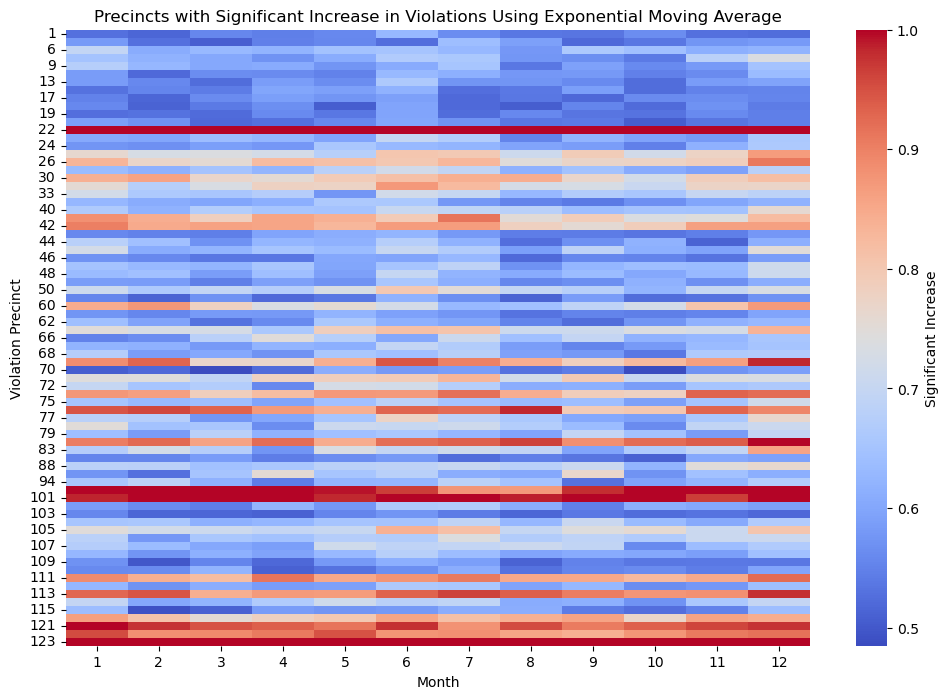

In [19]:
# daily violation counts for each precinct, day, & month
violation_counts = df_all.groupby(['Year', 'Month', 'Violation Precinct', 'Day']).size().reset_index(name='Daily Violations')

# aggregate daily violations using pivot_table -> handles duplicates
violation_pivot = pd.pivot_table(violation_counts, values='Daily Violations', index=['Year', 'Month', 'Violation Precinct', 'Day'], aggfunc='sum').reset_index()

# Exponential Moving Average (EMA) to smooth variations, resetting at the beginning of each month
violation_pivot['EMA'] = violation_pivot.groupby(['Violation Precinct', 'Year', 'Month'])['Daily Violations'].transform(lambda x: x.ewm(span=3, adjust=False).mean())

# Calculate total violations for the month
monthly_totals = violation_pivot.groupby(['Violation Precinct', 'Year', 'Month'])['Daily Violations'].transform('sum')

# Calculate total number of days in the month
days_in_month = violation_pivot.groupby(['Year', 'Month'])['Day'].transform('nunique')

# Calculate threshold as total violations divided by total days
violation_pivot['Threshold'] = monthly_totals / days_in_month

# Mark precincts with a significant increase
violation_pivot['Significant Increase'] = violation_pivot['EMA'] > violation_pivot['Threshold']

# visualization
plt.figure(figsize=(12, 8))
sns.heatmap(violation_pivot.pivot_table(index='Violation Precinct', columns='Month', values='Significant Increase'), cmap='coolwarm', cbar_kws={'label': 'Significant Increase'})
plt.title('Precincts with Significant Increase in Violations Using Exponential Moving Average')
plt.show()

# write to csv
violation_pivot.to_csv('../../data/final_data_to_join/ema_violation_counts.csv', index=False)

In [20]:
violation_pivot.head()

,Year,Month,Violation Precinct,Day,Daily Violations,EMA,Threshold,Significant Increase
0,2013,7,1,3,1,1.0,1.551724,False
1,2013,7,1,6,1,1.0,1.551724,False
2,2013,7,1,13,1,1.0,1.551724,False
3,2013,7,1,15,1,1.0,1.551724,False
4,2013,7,1,16,1,1.0,1.551724,False


Notes:
- ema threshhold: average daily violations for that month
- window (smothing factor alpha): spans past 3 days (can be changed)

In [21]:
# last 5 days of each month
violation_pivot['Day_rank'] = violation_pivot.groupby(['Year', 'Month'])['Day'].rank(ascending=False, method='min')
last_5_days = violation_pivot[violation_pivot['Day_rank'] <= 5].drop(columns=['Day_rank'])

# group by precinct, month, and year, and check if the last 5 days meet the condition
last_5_days_summary = last_5_days.groupby(['Violation Precinct', 'Year', 'Month'])['Significant Increase'].mean() > 0.5
last_5_days_summary = last_5_days_summary.reset_index(name='Last 5 Days Meet Condition')

# write to csv
last_5_days_summary.to_csv('../../data/final_data_to_join/potential_quotas.csv', index=False)

In [22]:
most_true_precinct = last_5_days_summary.groupby('Violation Precinct')['Last 5 Days Meet Condition'].sum().idxmax()
print("Precinct with the most True values:", most_true_precinct)

Precinct with the most True values: 25


## Visualizations

## Line Plot for EMA and Threshold

In [23]:
# unique_precincts = violation_pivot['Violation Precinct'].unique()

# # line plots
# plt.figure(figsize=(12, 6))
# for precinct in unique_precincts:
#     precinct_data = violation_pivot[violation_pivot['Violation Precinct'] == precinct]
#     plt.plot(precinct_data['Month'], precinct_data['EMA'], label=f'{precinct} - EMA')

# plt.title('EMA Over Time for Different Precincts')
# plt.xlabel('Month')
# plt.ylabel('EMA Value')
# plt.legend()
# plt.show()

## Heatmap for Significant Increase

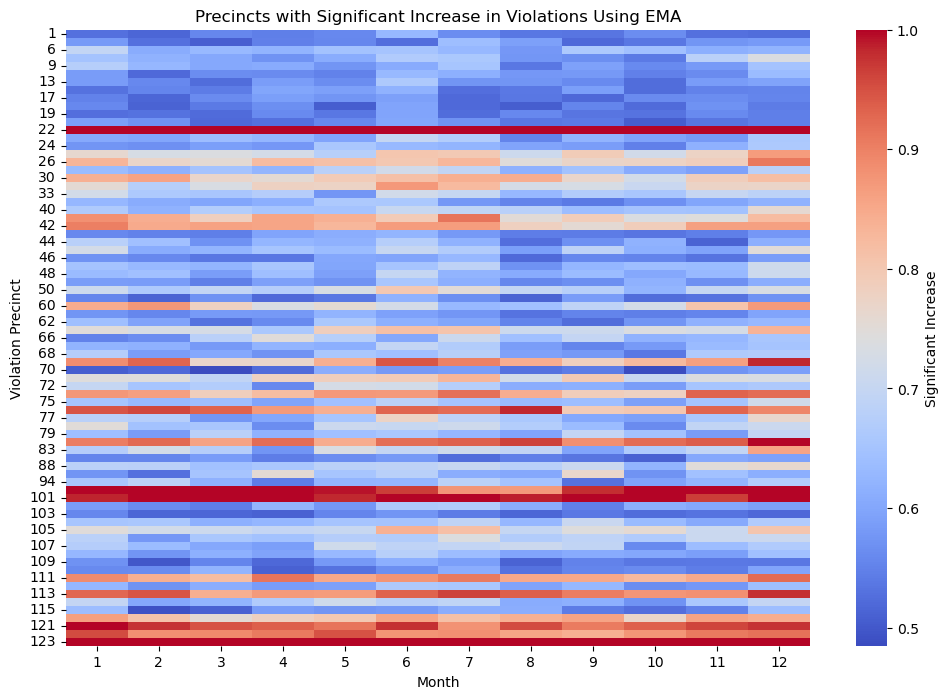

In [24]:
# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(violation_pivot.pivot_table(index='Violation Precinct', columns='Month', values='Significant Increase'), cmap='coolwarm', cbar_kws={'label': 'Significant Increase'})
plt.title('Precincts with Significant Increase in Violations Using EMA')
plt.show()

## Bar Plot for Last 5 Days

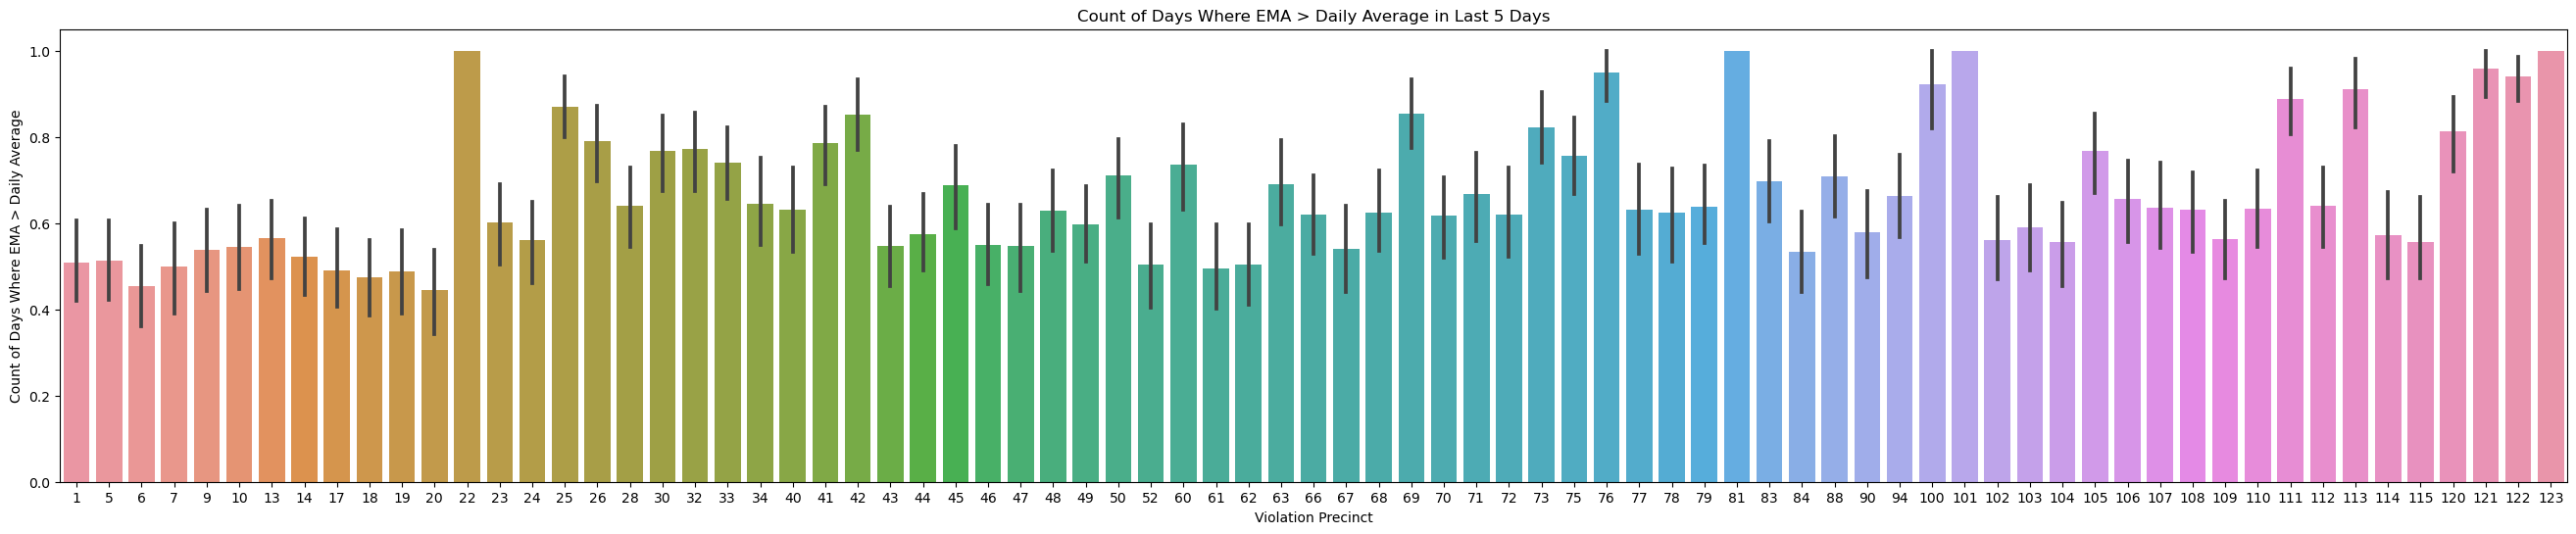

In [25]:
# bar plot
plt.figure(figsize=(33, 6))
sns.barplot(x='Violation Precinct', y='Last 5 Days Meet Condition', data=last_5_days_summary)
plt.title('Count of Days Where EMA > Daily Average in Last 5 Days')
plt.xlabel('Violation Precinct')
plt.ylabel('Count of Days Where EMA > Daily Average')
plt.show()